In [2]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import cv2


from PIL import Image
from keras.models import Model
from keras.applications import EfficientNetB0 , ResNet50 , EfficientNetB7
from keras.layers import (Layer , GlobalAveragePooling2D,Activation,MaxPooling2D,Add,Conv2D,MaxPool2D,Dense,Flatten,InputLayer,BatchNormalization,Input,
                          Embedding,Permute,Dropout,RandomFlip,RandomRotation,LayerNormalization,MultiHeadAttention,
                          RandomContrast,Rescaling,Resizing,Reshape,Cropping2D)
from keras.losses import BinaryCrossentropy,CategoricalCrossentropy,SparseCategoricalCrossentropy

from keras.metrics import Accuracy,TopKCategoricalAccuracy,CategoricalAccuracy,SparseCategoricalAccuracy
from keras.metrics import BinaryAccuracy, Accuracy,FalseNegatives,FalsePositives,TruePositives,TrueNegatives,Precision,Recall,AUC,binary_accuracy,CategoricalCrossentropy
from keras.optimizers import Adam, Adadelta
from keras.callbacks import Callback,EarlyStopping,LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
from keras.regularizers import L1,L2



In [3]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 224,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 10,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 4,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["Anthracite", "Bituminous", "Lignite","Peat"],
}

In [5]:
"""

pip install Augmentor
import Augmentor

def augment_photo(file_adress): 
    p= Augmentor.Pipeline(file_adress) #r"data\MuhammetAliSimsek"
    p.zoom(probability=0.3, min_factor=0.8, max_factor=1.5)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_top_bottom(probability=0.4)
    p.flip_left_right(probability=0.4)
    p.random_brightness(probability=0.3, min_factor=0.8, max_factor=1.5)
    p.rotate90(probability=0.1)
    p.sample(100)

"""



'\n\npip install Augmentor\nimport Augmentor\n\ndef augment_photo(file_adress): \n    p= Augmentor.Pipeline(file_adress) #r"data\\MuhammetAliSimsek"\n    p.zoom(probability=0.3, min_factor=0.8, max_factor=1.5)\n    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)\n    p.flip_top_bottom(probability=0.4)\n    p.flip_left_right(probability=0.4)\n    p.random_brightness(probability=0.3, min_factor=0.8, max_factor=1.5)\n    p.rotate90(probability=0.1)\n    p.sample(100)\n\n'

In [7]:
# augment_photo(file_adress=r"data/MuhammetAliSimsek")
# augment_photo(file_adress=r"data/ZekeriyyaKoroglu")
# augment_photo(file_adress=r"data/MuserrefSelcukOzdemir")
#augment_photo(file_adress=r"data/Diger")

In [8]:
data_directory = "/kaggle/input/coal-classification/Coal Classification"

# Dataset Loading

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

def dataset_loading():
    train_dataset = keras.utils.image_dataset_from_directory(
    data_directory,
    labels = "inferred",
    label_mode="categorical",
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode="rgb",
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.3,
    subset="training"
)
    validation_dataset = keras.utils.image_dataset_from_directory(
    data_directory,
    labels = "inferred",
    label_mode="categorical",
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode="rgb",
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset="validation"
)
    test_dataset = keras.utils.image_dataset_from_directory(
    data_directory,
    labels = "inferred",
    label_mode="categorical",
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode="rgb",
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.1,
    subset="validation"
)
    print(train_dataset)
    print(test_dataset)
    print(validation_dataset)
    return train_dataset,validation_dataset,test_dataset

In [ ]:
train_dataset,validation_dataset,test_dataset = dataset_loading()

Found 351 files belonging to 4 classes.
Using 246 files for training.
Found 351 files belonging to 4 classes.
Using 70 files for validation.
Found 351 files belonging to 4 classes.
Using 35 files for validation.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


# Dataset Vis

Corrupt JPEG data: 136 extraneous bytes before marker 0xd9


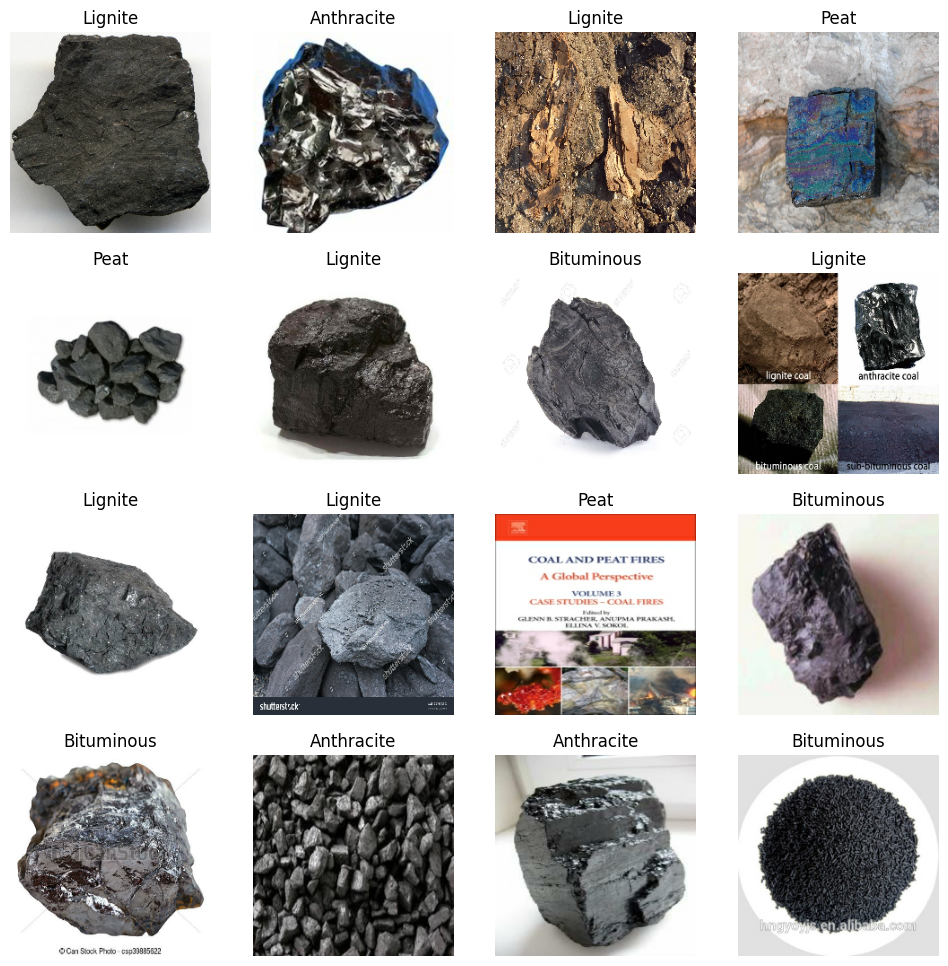

In [ ]:
plt.figure(figsize=(12,12))

for images,labels in train_dataset.take(2):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255)
        plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
        plt.axis("off")
    

# Dataset Preparation

In [ ]:
# https://www.tensorflow.org/guide/data_performance

train_dataset = (train_dataset.prefetch(tf.data.AUTOTUNE))
validation_dataset = (validation_dataset.prefetch(tf.data.AUTOTUNE))


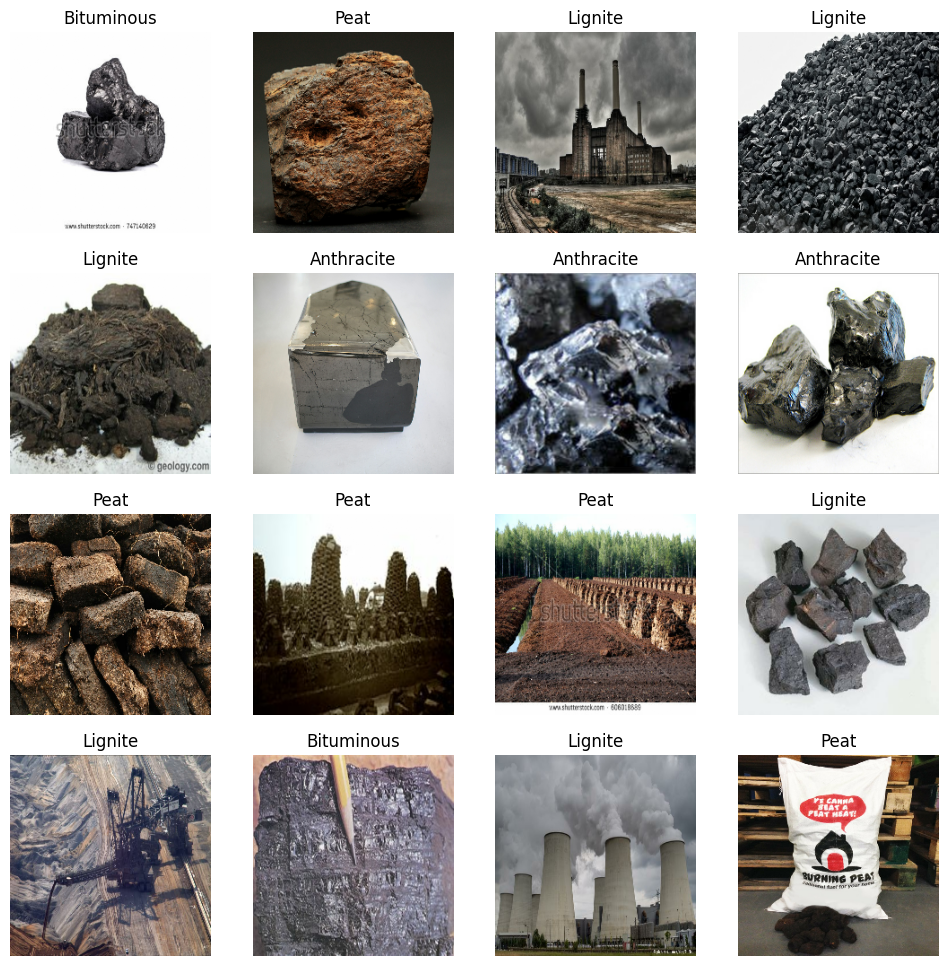

In [ ]:

plt.figure(figsize=(12,12))

for images,labels in validation_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255)
        plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
        plt.axis("off")
    




In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

# MODELING

# Callbacks

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint = ModelCheckpoint("fine_tuned_model.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:

early_stopping = EarlyStopping(
    monitor = "val_loss",
    min_delta=0,
    patience =6,
    verbose=0,
    mode = "auto",
    baseline = None,
    restore_best_weights = False
)

## Metrics

In [ ]:
metrics = [
    Accuracy(name="accuracy"),
    TruePositives(name="tp"),
    FalsePositives(name="fp"),
    TrueNegatives(name="tn"),
    FalseNegatives(name = "fn"),
    Precision(name = "precision"),
    Recall(name= "recall"),
    AUC(name = "auc"),

]

# Transfer Learning

### EfficentNetB0 - 224x224

In [ ]:
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

def build_efficentB0(num_classes):
    inputs = Input(shape=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    model.trainable = False
    # Kendi model yapımı

    x = GlobalAveragePooling2D(name = "avg_pool")(model.output)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.2

    x = Dropout(top_dropout_rate,name = "top_dropout")(x)
    outputs = Dense(num_classes,activation="softmax",name = "pred")(x)

    # Model

    model = Model(inputs,outputs,name = "EfficentNet")

    optimizer = Adam(learning_rate=0.00001)

    model.compile(
        optimizer=optimizer, loss = "categorical_crossentropy", metrics=["accuracy"]
    )
    return model

### EfficentNetB3 300*300

In [ ]:
def build_efficentB3(num_classes):
    inputs = Input(shape=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3))
    model = model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    model.trainable = False

    x = GlobalAveragePooling2D(name = "avg_pool")(model.output)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.2

    x = Dropout(top_dropout_rate,name = "top_dropout")(x)
    outputs = Dense(num_classes,activation="softmax",name = "pred")(x)

    model = Model(inputs,outputs,name = "EfficentNet")

    optimizer = Adam(learning_rate=0.00001)

    model.compile(
        optimizer=optimizer, loss = "categorical_crossentropy", metrics=metrics
    )
    return model

### EfficentNetB7 600x600

In [ ]:
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

def build_efficentB7(num_classes):
    inputs = Input(shape=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3))
    model = EfficientNetB7(include_top=False, input_tensor=inputs, weights="imagenet")

    model.trainable = False

    x = GlobalAveragePooling2D(name = "avg_pool")(model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)

    outputs = Dense(num_classes,activation="softmax",name = "pred")(x)

    model = Model(inputs,outputs,name = "EfficentNet")

    optimizer = Adam(learning_rate=0.00001)

    model.compile(
        optimizer=optimizer, loss = "categorical_crossentropy", metrics=metrics
    )
    return model

### Resnet50 224x224

In [ ]:
def build_resnet50(num_classes):
    inputs = Input(shape=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3))
    model = model = ResNet50(include_top=False, input_tensor=inputs, weights="imagenet")

    model.trainable = False

    x = GlobalAveragePooling2D(name = "avg_pool")(model.output)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.2

    x = Dropout(top_dropout_rate,name = "top_dropout")(x)
    outputs = Dense(num_classes,activation="softmax",name = "pred")(x)

    model = Model(inputs,outputs,name = "EfficentNet")

    optimizer = Adam(learning_rate=0.00001)

    model.compile(
        optimizer=optimizer, loss = "categorical_crossentropy", metrics=metrics
    )
    return model

### Freezing Layers

In [ ]:
# https://www.tensorflow.org/guide/keras/transfer_learning

def unfreeze_model(model, start_layer, end_layer):
    for layer in model.layers[start_layer:end_layer]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])





# Model Training

In [ ]:
model = build_efficentB0(CONFIGURATION["NUM_CLASSES"])

In [ ]:
unfreeze_model(model,-10,None)

In [ ]:
history = model.fit(train_dataset,validation_data=validation_dataset,epochs=10,callbacks = [checkpoint,early_stopping])

Epoch 1/10


Corrupt JPEG data: 136 extraneous bytes before marker 0xd9


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3372 - loss: 1.7234
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to fine_tuned_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3399 - loss: 1.7304 - val_accuracy: 0.5000 - val_loss: 1.1305
Epoch 2/10


Corrupt JPEG data: 136 extraneous bytes before marker 0xd9


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7392 - loss: 0.6257
Epoch 2: val_accuracy did not improve from 0.50000
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7388 - loss: 0.6336 - val_accuracy: 0.4857 - val_loss: 1.1783
Epoch 3/10


Corrupt JPEG data: 136 extraneous bytes before marker 0xd9


5/8 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8279 - loss: 0.4798

KeyboardInterrupt: 

## Model Save

In [ ]:
model.save("efficent_net_efficent224.h5")
model.save("efficent_net_efficent224.keras")

In [ ]:
model.evaluate(test_dataset)